In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
%config InlineBackend.figure_format = 'svg'

# self-consistent sulotion of electron hole

In [78]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 60


vmax = 10 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## 静态$Sech^{4/3}$分布
$$ f_u(w>0) = \frac{1}{\sqrt{2\pi}} e^{-w} $$
$$ f_t(w<0) = \frac{1}{\sqrt{2\pi}}(1 -w -\alpha w^2) $$
其中$w=v^2/2-\phi$
- 要求：$v=0$是极小值，并$f(v=0)>0$
$$\frac{d^2 f_t(v=0)}{dv^2} > 0 \Rightarrow \alpha > \frac{1}{2\psi}$$ 
$$f_t(v=0)>0 \Rightarrow \alpha < \frac{1+\psi}{\psi^2}$$
- $\alpha$越大，$\psi$越小

In [79]:
psi = 0.085
alpha_min = 0.5/psi
alpha_max = (1+psi)/psi**2
print("alpha_min",alpha_min)
print("alpha_max",alpha_max)

alpha_min 5.88235294117647
alpha_max 150.1730103806228


In [84]:
alpha = 100
xp = (x-L/2)/4.0*3.0
phi = psi*np.cosh(xp)**(-4/3)

In [85]:
@nb.jit
def nonvec_f_fun_sech43(v,phi):
    r = 0
    w = (v**2)/2-phi
    if w>0:
        r = math.exp(-((2*w)**0.5)**2/2) 
    else:
        r = 1 - w - alpha*w**2
    return r/(2*np.pi)**0.5

f_fun_sech43 = np.vectorize(nonvec_f_fun_sech43)

In [88]:
for count in tqdm(range(100)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech43(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-5:
        print("Sucess! Iteration counts =", count)
        print("err =", err)
        break

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Sucess! Iteration counts = 0
err = 1.1762443883590034e-06


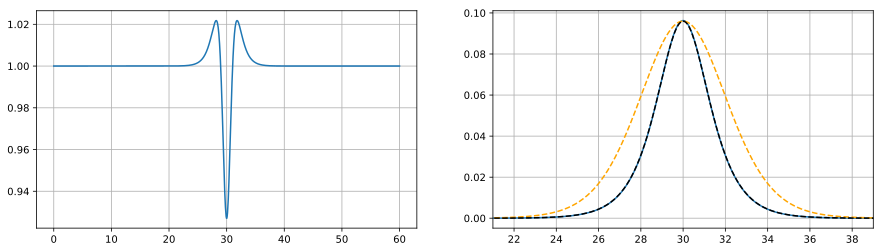

In [89]:
psi = 0.096
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.grid()
# ax2 = plt.subplot(132)
# ax2.plot(x,E)
# ax2.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi)
ax3.plot(x,psi*np.cosh((x-L/2)/4)**(-4),color='orange',linestyle='--')
ax3.plot(x,psi*np.cosh((x-L/2)/4*3)**(-4/3),color='black',linestyle='--')
ax3.grid()
ax3.set_xlim(0.35*L,0.65*L)
plt.show()

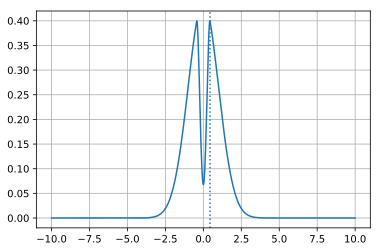

In [90]:
V,Phi=np.meshgrid(v,phi)
f_matrix = f_fun_sech43(V,Phi)
fv = f_matrix.sum(axis=0)*dx/L
plt.plot(v,f_matrix[500,])
plt.axvline(np.sqrt(2*psi),linestyle=':')
# plt.xlim(0.2,0.6)
# plt.ylim(0.3,0.41)
plt.grid()

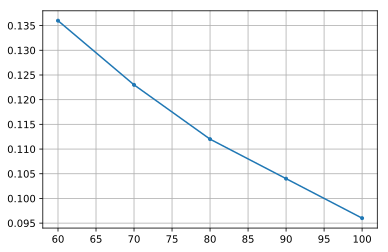

In [91]:
# a_list = [90,80,70,60,50,40,30,20,10,5,2]
# psi_list = [0.104,0.112,0.123,0.136,0.155,0.181,0.22,0.29,0.471,0.78,1.54]
a_list = [100,90,80,70,60]
psi_list = [0.096,0.104,0.112,0.123,0.136]
plt.plot(a_list,psi_list,'.-')
plt.grid()
plt.show()